In [1]:
import sys
import getopt
import math
import numpy as np
from netCDF4 import Dataset as NC
import matplotlib.pyplot as plt
import tqdm
from scipy import ndimage
from scipy import spatial
from copy import deepcopy
import subprocess
import rasterio
from rasterio.plot import show
import geopandas as gpd
from funcs import *
from scipy.ndimage import zoom
from sklearn.metrics import mean_squared_error
from rasterio import mask as msk

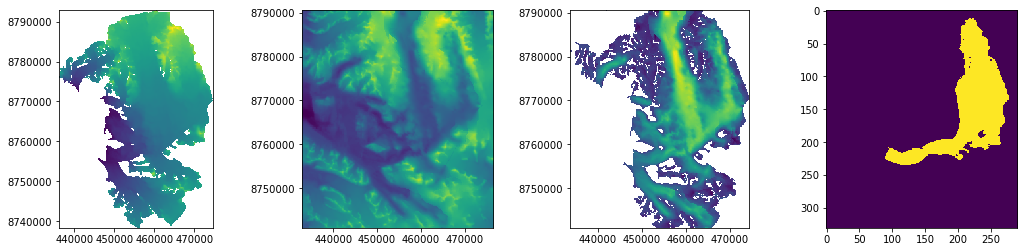

In [2]:
### data from lindbäck et al. (2018)
surf_o = rasterio.open("./kronebreen/TIGRIF_DEM_ice_surface_150m_v1.tif") #from 2014
thk_o = rasterio.open("./kronebreen/TIGRIF_DEM_ice_thickness_150m_1.tif") #from 2014, 2015, 2016 and some from 2000s
bed_o = rasterio.open("./kronebreen/TIGRIF_DEM_subglacial_elevation_150m_v1.tif")

surf = surf_o.read(1)
thk = thk_o.read(1)
bed = bed_o.read(1)

### rgi outline
outline = gpd.read_file('./kronebreen/rgi_outlines/07_rgi60_Svalbard.shp')
outline_Kr = outline.to_crs(bed_o.crs)
outline_Kr = outline_Kr.loc[outline_Kr['RGIId'] == 'RGI60-07.01464', 'geometry']

bed_mask, bed_mask_meta = rasterio.mask.mask(bed_o, outline_Kr, crop=False)
surf_mask, surf_mask_meta = msk.mask(surf_o, outline_Kr, crop=False)
thk_mask, thk_mask_meta = msk.mask(thk_o, outline_Kr, crop=False)
mask_Kr = np.ones_like(bed_mask[0])
mask_Kr[bed_mask[0]>1e37]=0

fig, ax = plt.subplots(1,4, figsize=(18,4))
field1 = show(surf_o, ax = ax[0])
field2 = show(bed_o, ax = ax[1])
field3 = show(thk_o, ax = ax[2])
#outline.plot(ax=ax[2])
field4 = show(mask_Kr)

In [3]:
#### data from Jack ###
import scipy.io
mat_DEM_Vel = scipy.io.loadmat('./kronebreen/HDF_2021_10_06.mat')
x_50m, y_50m = np.meshgrid(mat_DEM_Vel['HDF'][0,0][0], np.arange(np.min(mat_DEM_Vel['HDF'][0,0][1]), np.max(mat_DEM_Vel['HDF'][0,0][1])+10050, 50))

Z_50m_09 = np.zeros((int(((np.max(y_50m)+50)-np.min(y_50m))/50), int((np.max(x_50m)+50-np.min(x_50m))/50)))
Z_50m_09[:np.shape(Z_50m_09)[0]-int(10000/50),:] = mat_DEM_Vel['HDF'][0,0][3]
Z_50m_14 = np.zeros((int(((np.max(y_50m)+50)-np.min(y_50m))/50), int((np.max(x_50m)+50-np.min(x_50m))/50)))
Z_50m_14[:np.shape(Z_50m_14)[0]-int(10000/50),:] = mat_DEM_Vel['HDF'][0,0][4]

R2_50m_Vx = mat_DEM_Vel['HDF'][0,0][6]
R2_50m_Vx[np.isnan(R2_50m_Vx)] = 0
R2_50m_Vy = mat_DEM_Vel['HDF'][0,0][7]
R2_50m_Vy[np.isnan(R2_50m_Vy)] = 0
R2_50m_Vel = mat_DEM_Vel['HDF'][0,0][8]
R2_50m_Vel[np.isnan(R2_50m_Vel)] = 0

mat_RADAR = scipy.io.loadmat('./kronebreen/HDF_radar_data.mat')
x_rad = mat_RADAR['HDF_radar_data'][0,0][0]
y_rad = mat_RADAR['HDF_radar_data'][0,0][1]
xy_rad = np.stack([x_rad, y_rad], axis=1)[:,:,0]
rad = mat_RADAR['HDF_radar_data'][0,0][2]

In [4]:
### official 50 m NPI DEM ###
NPI_DEM_o = rasterio.open("./kronebreen/S0_DTM50.tif")
window = (NPI_DEM_o.window(np.min(x_50m), np.min(y_50m), np.max(x_50m), np.max(y_50m),1))
NPI_50m_DEM = np.zeros_like(Z_50m_09)
NPI_50m_DEM[1:,1:] = np.flip(NPI_DEM_o.read(1, window = window), axis=0)  ## NPI_DEM is not correctly oriented when imported (no idea why), therefore it needs to be flipped

In [5]:
### get mask of Kongsbreen, reproject it and set it to the correct spot in the raster ###
outline_Ko = outline.to_crs(NPI_DEM_o.crs)
outline_Ko = outline_Ko.loc[outline_Ko['RGIId'] == 'RGI60-07.01482', 'geometry']
NPI_mask, NPI_mask_meta = rasterio.mask.mask(NPI_DEM_o, outline_Ko, crop=True)
NPI_mask = np.flip(NPI_mask[0], axis=0)
NPI_mask[NPI_mask<-1e37] = 0
NPI_mask[NPI_mask>0] = 1

#coordinates of upper left corner of cropped (using window) NPI DEM
x_ul_NPI_DEM = window.col_off*50+NPI_DEM_o.transform[2]  
y_ul_NPI_DEM = window.row_off*-50+NPI_DEM_o.transform[5]

## amount of pixels that NPI_mask needs to be shifted to be at right spot in the raster
shift_x = int((NPI_mask_meta[2] - x_ul_NPI_DEM)/50)
shift_y = int((NPI_mask_meta[5] - y_ul_NPI_DEM)/50)

mask_50m_Ko = np.zeros_like(NPI_50m_DEM)
mask_50m_Ko[(np.shape(mask_50m_Ko)[0]-np.shape(NPI_mask)[0]+shift_y):(np.shape(mask_50m_Ko)[0]+shift_y), shift_x:(shift_x+np.shape(NPI_mask)[1])]=NPI_mask

In [6]:
### masks ###
#mask_50m = -1*np.logical_or(np.isnan(Z_50m_14), np.isnan(Z_50m_09))+1
mask_50m = -1*np.isnan(Z_50m_14)+1
retreat_50m_mask = np.zeros_like(mask_50m)
retreat_50m_mask[np.logical_and(NPI_50m_DEM<100, np.logical_and(Z_50m_09>1, -1*mask_50m+1))] = 1
retreat_50m_mask[retreat_50m_mask+mask_50m==2]=0

#retreat_50m_mask = np.logical_and(np.logical_and(-1*np.isnan(Z_50m_09)+1, mask_50m == 0), NPI_50m_DEM < 100)

#mask_50m *= (-1*retreat_50m_mask+1)

mask_50m[np.shape(mask_50m)[0]-int(10000/50):,:]=0

mask_50m_full = mask_50m_Ko + mask_50m
mask_50m_full[mask_50m_full>0] = 1

In [7]:
### set bed elevation under water to -700 m ###
#ocean_50m = (np.logical_and(NPI_50m_DEM<=10, mask_50m==0))
NPI_50m_DEM[retreat_50m_mask==1] = 0

### fill nan values ###
Z_50m_09[mask_50m_full==0]=NPI_50m_DEM[mask_50m_full==0]
Z_50m_09[np.isnan(Z_50m_09)] = NPI_50m_DEM[np.isnan(Z_50m_09)]

Z_50m_14[mask_50m_full==0]=NPI_50m_DEM[mask_50m_full==0]
Z_50m_14[np.isnan(Z_50m_14)] = NPI_50m_DEM[np.isnan(Z_50m_14)]

### calculate dhdt ###
dhdt_50m_0914 = (Z_50m_14 - Z_50m_09)/5
dhdt_50m_0914[np.isnan(dhdt_50m_0914)] = 0

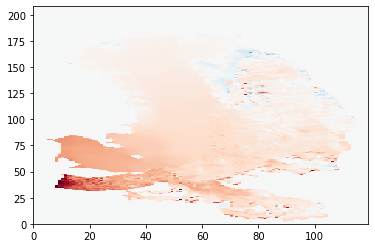

In [8]:
## fit dhdt for Kongsbreen ##
poly = np.poly1d(np.polyfit(NPI_50m_DEM[mask_50m == 1],dhdt_50m_0914[mask_50m == 1],1))
dhdt_50m_fit = poly(NPI_50m_DEM)
dhdt_50m_fit[mask_50m == 1]=0
dhdt_50m_fit[mask_50m_Ko == 0]=0

## full dhdt
dhdt_50m_full = dhdt_50m_fit+dhdt_50m_0914

plt.pcolor(zoom(dhdt_50m_full, 50/250), cmap='RdBu', vmin=-5, vmax=5)

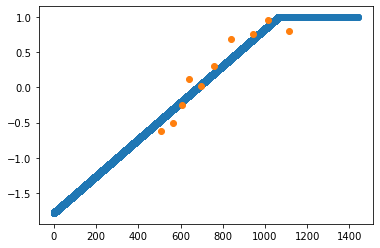

In [9]:
### mass balance from Jack in cm.w.eq. ###
import pandas as pd

smb_xyz_df = pd.read_excel ('./kronebreen/HDF_mass_balance.xlsx', 0, header=None)
smb_net_df = pd.read_excel ('./kronebreen/HDF_mass_balance.xlsx', 3, header=None)

smb_x = np.array(smb_xyz_df.loc[:,1])
smb_y = np.array(smb_xyz_df.loc[:,2])
smb_z = np.array(smb_xyz_df.loc[:,3])

smb_net_0914 = np.array(smb_net_df.loc[1:,7:12])/100*(10/9)   #convert to m.ice.eq.
smb_net_0914 = np.nanmean(smb_net_0914, axis=1)

### interpolate smb with elevation ###
from scipy import optimize

#def piecewise_linear(x):
#    return np.piecewise(x, [x < 0, x>=0], [lambda x: -x, lambda x: x])

#p , e = optimize.curve_fit(piecewise_linear, smb_z, smb_net_1421)
#test = piecewise_linear(Z_14, *p)

poly = np.poly1d(np.polyfit(smb_z,smb_net_0914,1))
smb_50m_fit = poly(NPI_50m_DEM)
smb_50m_fit[smb_50m_fit<-2] = -2
smb_50m_fit[smb_50m_fit>1] = 1


plt.scatter(NPI_50m_DEM, smb_50m_fit)
plt.scatter(smb_z, smb_net_0914)

In [10]:
### velocity from Jack ###
vel_xyz_df = pd.read_excel('./kronebreen/HDF_stake_velocities.xlsx', 1, header=None)
vel_x = np.array(vel_xyz_df.loc[:,1])
vel_y = np.array(vel_xyz_df.loc[:,2])
vel_z = np.array(vel_xyz_df.loc[:,3])

vel_df = pd.read_excel ('./kronebreen/HDF_stake_velocities.xlsx', 0, header=None)
vel_0914 = np.nanmean(np.array(vel_df.loc[3:,range(10,18,2)]), axis=1)


In [11]:
### adjust resolution ###

data_res = 50
res = 250
resample = data_res/res

Z_09 = zoom(Z_50m_09, resample)
Z_14 = zoom(Z_50m_14, resample)
dhdt_full = zoom(dhdt_50m_full, resample)
smb_fit = zoom(smb_50m_fit, resample)
NPI_DEM = zoom(NPI_50m_DEM, resample)
R2_Vel = zoom(R2_50m_Vel, resample)
R2_Vx = zoom(R2_50m_Vy, resample)
R2_Vy = zoom(R2_50m_Vy, resample)

mask = np.around(zoom(mask_50m_full, resample), 0)
mask_Kr = np.around(zoom(mask_50m, resample), 0)
mask_Ko = np.around(zoom(mask_50m_Ko, resample), 0)

retreat_mask = NPI_DEM<-500

x = zoom(x_50m, resample)
y = zoom(y_50m, resample)

In [13]:
#import rioxarray as rxr
#vx_test = rxr.open_rasterio("./kronebreen/SRA_G0120_0000_vx.tif")
#vy_test = rxr.open_rasterio("./kronebreen/SRA_G0120_0000_vy.tif")
#''''
#outline_test = outline.to_crs(vx_test.rio.crs)
#outline_test = outline_test.loc[outline_test['RGIId'] == 'RGI60-07.01464', 'geometry']
#vx_test = vx_test.rio.clip_box(**outline_test.bounds)
#vy_test = vy_test.rio.clip_box(**outline_test.bounds)
#'''
#vx_test = vx_test.rio.reproject(NPI_DEM_o.crs)
#vx_test = vx_test.rio.clip_box(np.min(x_50m), np.min(y_50m), np.max(x_50m), np.max(y_50m))
#vx_test = np.flip(zoom(vx_test.data[0,:,:], vx_test.rio.resolution()[0]/res), axis = 0)

In [82]:
import glob
vel_files = sorted(glob.glob('./kronebreen/SRA_G0240_20*_v.tif'))
vel_files.append('./kronebreen/SRA_G0120_0000_v_err.tif')

for file in vel_files:
    with rasterio.open(file) as src:
        transform, width, height = rasterio.warp.calculate_default_transform(
            src.crs, NPI_DEM_o.crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': NPI_DEM_o.crs,
            'transform': transform,
            'width': width,
            'height': height
        })
    
        with rasterio.open('{}_proj.tif'.format(file), 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                rasterio.warp.reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=NPI_DEM_o.crs,
                    resampling=rasterio.warp.Resampling.nearest)

In [109]:
itslive_vel09_o = rasterio.open('./kronebreen/SRA_G0240_2009_v.tif_proj.tif')
window_vels = itslive_vel09_o.window(np.min(x_50m), np.min(y_50m), np.max(x_50m), np.max(y_50m),1)
itslive_vel_09 = zoom(np.maximum(0, np.flip(itslive_vel09_o.read(1, window = window_vels), axis = 0)), itslive_vel09_o.res[0]/res)

itslive_vel10_o = rasterio.open('./kronebreen/SRA_G0240_2010_v.tif_proj.tif')
itslive_vel_10 = zoom(np.maximum(0, np.flip(itslive_vel10_o.read(1, window = window_vels), axis = 0)), itslive_vel09_o.res[0]/res)

itslive_vel11_o = rasterio.open('./kronebreen/SRA_G0240_2011_v.tif_proj.tif')
itslive_vel_11 = zoom(np.maximum(0, np.flip(itslive_vel11_o.read(1, window = window_vels), axis = 0)), itslive_vel09_o.res[0]/res)

itslive_vel12_o = rasterio.open('./kronebreen/SRA_G0240_2012_v.tif_proj.tif')
itslive_vel_12 = zoom(np.maximum(0, np.flip(itslive_vel12_o.read(1, window = window_vels), axis = 0)), itslive_vel09_o.res[0]/res)

itslive_vel13_o = rasterio.open('./kronebreen/SRA_G0240_2013_v.tif_proj.tif')
itslive_vel_13 = zoom(np.maximum(0, np.flip(itslive_vel13_o.read(1, window = window_vels), axis = 0)), itslive_vel09_o.res[0]/res)

itslive_vel14_o = rasterio.open('./kronebreen/SRA_G0240_2014_v.tif_proj.tif')
itslive_vel_14 = zoom(np.maximum(0, np.flip(itslive_vel14_o.read(1, window = window_vels), axis = 0)), itslive_vel09_o.res[0]/res)

itslive_err_o = rasterio.open('./kronebreen/SRA_G0120_0000_v_err.tif_proj.tif')
itslive_err = np.zeros_like(NPI_DEM)
window_err = itslive_err_o.window(np.min(x_50m), np.min(y_50m), np.max(x_50m), np.max(y_50m),1)
itslive_err[:,1:] = zoom(np.flip(itslive_err_o.read(1, window = window_err), axis = 0), itslive_err_o.res[0]/res)

vels_mes = np.zeros_like(NPI_DEM)
vels_mes[:,1:] = np.mean([itslive_vel_09, itslive_vel_10, itslive_vel_11, itslive_vel_12, itslive_vel_13, itslive_vel_14], axis = 0)

/tmp/ipykernel_8093/2053341374.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.pcolor(itslive_err/vels_mes*mask, vmax = .5, vmin = 0)


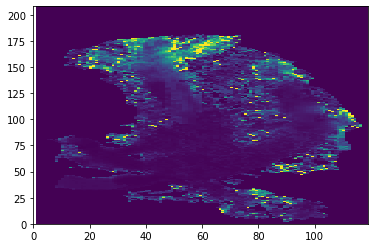

In [120]:
plt.pcolor(itslive_err/vels_mes*mask, vmax = .5, vmin = 0)

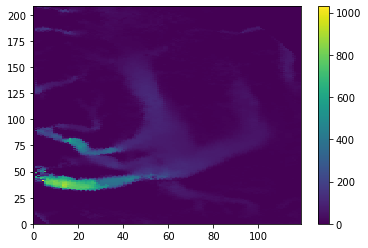

In [18]:
### ITS_LIVE velocities
itslive_vel_o = rasterio.open("./kronebreen/vel_ITSLIVE_resample.tif")
itslive_vx_o = rasterio.open("./kronebreen/vx_ITSLIVE_proj.tif")
itslive_vy_o = rasterio.open("./kronebreen/vy_ITSLIVE_proj.tif")

window_vel = (itslive_vel_o.window(np.min(x_50m), np.min(y_50m), np.max(x_50m), np.max(y_50m),1))
itslive_vel = np.flip(itslive_vel_o.read(1, window = window_vel), axis = 0)
itslive_vx = np.flip(itslive_vx_o.read(1, window = window_vel), axis = 0)
itslive_vy = np.flip(itslive_vy_o.read(1, window = window_vel), axis = 0)

vel_mes = np.zeros_like(mask)
vel_mes[:,1:] = itslive_vel
vel_mes[vel_mes<-1e30] = 0

vx_mes = np.zeros_like(mask)
vx_mes[:,1:] = itslive_vx
vx_mes[vel_mes<-1e30] = 0

vy_mes = np.zeros_like(mask)
vy_mes[:,1:] = itslive_vy
vy_mes[vel_mes<-1e30] = 0

fig, ax = plt.subplots()
field = ax.pcolor(vel_mes)
plt.colorbar(field, ax = ax)

In [16]:
#gr = np.meshgrid(range(119), range(208))
#index_y = get_nearest(x,y,gr[1],x_rad, y_rad)
#index_x = get_nearest(x,y,gr[0],x_rad, y_rad)
#grid_points = list(set(zip(index_y, index_x)))
#
#n = int(len(grid_points)/10)
#random_index = np.random.choice(len(grid_points), n, replace=False)  
#grid_points_random = [grid_points[i] for i in random_index]
#bed_loc_random = [rad[i] for i in random_index]
#grid_points_location = [tuple(i) for i in np.array(grid_points)[np.logical_and(np.array(grid_points)[:,1]<50, np.array(grid_points)[:,0]<200)]]
#
#radar_mask = np.zeros_like(NPI_DEM)
#for i,q in enumerate(grid_points):
#    radar_mask[q]=rad[i]

In [19]:
### filter outliers in dhdt ###
dhdt_full_new = np.zeros_like(dhdt_full)
for i in range(np.shape(dhdt_full)[0]):
    for j in range(np.shape(dhdt_full)[1]):
        if mask[i, j]==0:
                dhdt_full_new[i, j] = 0
        else:
            y_f, x_f = np.ogrid[:np.shape(dhdt_full)[0], :np.shape(dhdt_full)[1]]
            circle = (y_f - i) ** 2 + (x_f - j) ** 2 <= 20
            local_med = np.median(dhdt_full[np.logical_and(circle, mask==1)])
            local_std = np.std(dhdt_full[np.logical_and(circle, mask==1)])
            if dhdt_full[i,j] >  local_med + 1* local_std:
                dhdt_full_new[i, j]= local_med + 1* local_std
            elif dhdt_full[i,j] < local_med - 1* local_std:
                dhdt_full_new[i, j]= local_med - 1* local_std              
            else:
                dhdt_full_new[i,j] = dhdt_full[i,j]

In [20]:
### ice temperature ###
ice_temp = 273
A = 1.733e3*np.exp(-13.9e4/(8.3*ice_temp))
print(A)

3.9565534675428266e-24


In [21]:
filename = "kronebreen_kongsbreen_conf.nc"
nc = NC(filename, 'w', format="NETCDF3_CLASSIC")
var = nc.createVariable("pism_overrides", 'i')

attrs = {#"ocean.always_grounded": "yes",
         "geometry.update.use_basal_melt_rate": "no",
         "stress_balance.ssa.compute_surface_gradient_inward": "no",
         "flow_law.isothermal_Glen.ice_softness": A,
         "constants.ice.density": 900.,
         "constants.sea_water.density": 1000.,
         "bootstrapping.defaults.geothermal_flux": 0.0,
         "stress_balance.ssa.Glen_exponent": 3.,
         "constants.standard_gravity": 9.8,
         "ocean.sub_shelf_heat_flux_into_ice": 0.0,
         "stress_balance.sia.bed_smoother.range": 0.0,
         }

for name, value in attrs.items():
    var.setncattr(name, value)

nc.close()

In [22]:
WRIT_FILE = 'kronebreen_kongsbreen_initialSetup.nc'

### CONSTANTS ###

secpera = 31556926.
ice_density = 900.0             # [kg m-3]

ny, nx = np.shape(Z_09)
Lx = nx * res  # in m
Ly =  ny * res # in m

x_in = np.linspace(-Lx/2, Lx/2, nx)
y_in = np.linspace(-Ly/2, Ly/2, ny)

B_rec = NPI_DEM
B_init = deepcopy(B_rec)
ice_surface_temp = np.ones((ny, nx))*ice_temp
#M_refs = np.nan_to_num(M_refs)
#M_refs *= mask

h_rec = NPI_DEM - B_rec

##### define variables, set attributes, write data #####
# format: ['units', 'long_name', 'standard_name', '_FillValue', array]

vars = {'y':    ['m',
                 'y-coordinate in Cartesian system',
                 'projection_y_coordinate',
                 None,
                 y_in],
        'x':    ['m',
                 'x-coordinate in Cartesian system',
                 'projection_x_coordinate',
                 None,
                 x_in],
        'thk':  ['m',
                 'ice thickness',
                 'land_ice_thickness',
                 1.0,
                 h_rec],
        'topg': ['m',
                 'bedrock surface elevation',
                 'bedrock_altitude',
                 0.0,
                 B_rec],
        'ice_surface_temp': ['K',
                             'annual mean air temperature at ice surface',
                             'surface_temperature',
                             273,
                             ice_surface_temp],
        'climatic_mass_balance': ['kg m-2 year-1',
                                  'mean annual net ice equivalent accumulation rate',
                                  'land_ice_surface_specific_mass_balance_flux',
                                  0,
                                  smb_fit * ice_density * mask]
        }

##### define dimensions in NetCDF file #####
def create_nc_input(vars, WRIT_FILE):
    ncfile = NC(WRIT_FILE, 'w', format='NETCDF3_CLASSIC')
    xdim = ncfile.createDimension('x', nx)
    ydim = ncfile.createDimension('y', ny)
    
    for name in list(vars.keys()):
        [_, _, _, fill_value, data] = vars[name]
        if name in ['x', 'y']:
            var = ncfile.createVariable(name, 'f4', (name,))
        else:
            var = ncfile.createVariable(name, 'f4', ('y', 'x'), fill_value=fill_value)
        for each in zip(['units', 'long_name', 'standard_name'], vars[name]):
            if each[1]:
                setattr(var, each[0], each[1])
        var[:] = data
    
    # finish up
    ncfile.close()
    print("NetCDF file ", WRIT_FILE, " created")
    print('')
    
create_nc_input(vars, WRIT_FILE)

NetCDF file  kronebreen_kongsbreen_initialSetup.nc  created



In [23]:
def scale(x):
    return (x-np.nanmin(x))/(np.nanmax(x)-np.nanmin(x))

def gauss_filter(U, sigma, truncate):

    V=U.copy()
    V[np.isnan(U)]=0
    VV=ndimage.gaussian_filter(V,sigma=sigma,truncate=truncate)

    W=0*U.copy()+1
    W[np.isnan(U)]=0
    WW=ndimage.gaussian_filter(W,sigma=sigma,truncate=truncate)

    Z=VV/WW
    return Z

def get_nearest(x_ref,y_ref,reference, x_dat, y_dat):
    grid_temp = []
    for i in range(len(x_dat)):
        abslat = np.abs(x_ref-x_dat[i])
        abslon= np.abs(y_ref-y_dat[i])

        c = np.maximum(abslon,abslat)
        latlon_idx = np.argmin(c)
        grid_temp.append(reference.flat[latlon_idx])
    return grid_temp

def neighbors(a, radius, rowNumber, columnNumber):
     return [[a[i][j] if  i >= 0 and i < len(a) and j >= 0 and j < len(a[0]) else 0
                for j in range(columnNumber-1-radius, columnNumber+radius)]
                    for i in range(rowNumber-1-radius, rowNumber+radius)]

In [24]:
def create_script(forward_or_iteration, nx, ny):
    print("""#!/bin/bash
    ###### run script for experiment synthetic1 ######""")
    print('# build the PISM command')
    print('set -e #exit on error')
    print('')
    print('NN="$1"')
    print('CLIMATEFILE="$2"')
    print('DURATION=$3')
    print('OUTNAME=$4')
    print('OPT5=$5')
    print('RUNTIME="-ys 0 -ye $DURATION"')
    
    print('')
    print('CLIMATE="-surface given -surface_given_file $CLIMATEFILE"')
    print('grid="-Mx {} -My {} -Mz 50 -Mbz 1 -Lz 1500 -Lbz 1"'.format(nx, ny))
    print('PHYS="-stress_balance ssa+sia -sia_flow_law isothermal_glen -ssa_flow_law isothermal_glen"')# -basal_resistance.beta_lateral_margin 0"')
    print('THERMAL="-energy none"')
    #print('OCEAN="-dry"')
    print('CONF="-config_override kronebreen_kongsbreen_conf.nc"')

    # power law sliding relation t_b=-C*|u|^(m-1)*u --> doesn't require thermal model
    print('SLIDING="-pseudo_plastic -pseudo_plastic_q 0.2 -pseudo_plastic_uthreshold 3.1556926e7 -yield_stress constant -tauc 1e5"')
    
    print('echo')
    print('echo "# ======================================================================="')
    print('echo "# initialize Kronebreen"')
    print('echo "#  $NN processors, $DURATION a run, 50 km grid, $CLIMATEFILE, $4"')
    print('echo "# ======================================================================="')
    
    print('')
    print('PISM_MPIDO="mpiexec -n "')
    
    print('')
    print('PISM_BIN=/home/thomas/pism/bin')
    print('PISM_EXEC="pismr"')
    print('EXVARS="temppabase,tempicethk_basal,velsurf_mag,mask,thk,usurf,velbase_mag,enthalpybase,bwat,strain_rates"')
    
    print('')
    print('PISM="${PISM_BIN}/${PISM_EXEC}"')
    
    print('')
    print('EXSTEP=100')
    print('TSNAME=ts_$OUTNAME')
    print('TSTIMES=0:yearly:$DURATION')
    print('EXNAME=ex_$OUTNAME')
    print('EXTIMES=0:$EXSTEP:$DURATION')
    print('DIAGNOSTICS="-ts_file $TSNAME -ts_times $TSTIMES -extra_file $EXNAME -extra_times $EXTIMES -extra_vars $EXVARS -o_size big"')
    
    print('DIAGNOSTICS_ITER="-save_file s_$OUTNAME -save_times $OPT5 -save_force_output_times -o_size big -extra_vars $EXVARS"')
    
    print('')
    if forward_or_iteration == 'forward':
        print('cmd="$PISM_MPIDO $NN $PISM -i $CLIMATEFILE -bootstrap ${grid} $CONF $SLIDING $THERMAL $OCEAN $RUNTIME $CLIMATE $PHYS $DIAGNOSTICS -o $OUTNAME"')
    elif forward_or_iteration == 'iteration':
        print('cmd="$PISM_MPIDO $NN $PISM -i $CLIMATEFILE $CONF $ENHANCE $SLIDING $THERMAL $OCEAN $RUNTIME $CLIMATE $PHYS $DIAGNOSTICS_ITER -o $OUTNAME"')
    
    print('')
    print('echo')
    print('$cmd')

In [25]:
original_stdout = sys.__stdout__ # Save a reference to the original standard output
with open('kronebreen_kongsbreen_initialize.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    create_script('forward', nx, ny)
    sys.stdout = original_stdout # Reset the standard output to its original value
    f.close()
    
!chmod +x kronebreen_kongsbreen_initialize.sh
!./kronebreen_kongsbreen_initialize.sh 4 kronebreen_kongsbreen_initialSetup.nc 1 kronebreen_kongsbreen_output.nc > kronebreen_kongsbreen_output_log.txt

Tau: 1.3920452871665763
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
dH: 1.4064830798891736
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotr

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top 


A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.001122


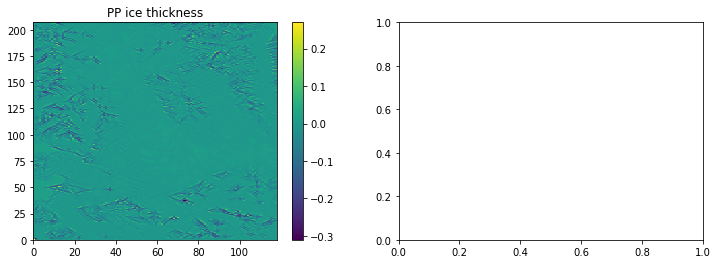

In [26]:
import richdem as rd
import math

dH = (np.nanmax(NPI_DEM[mask==1])-np.nanmin(NPI_DEM[mask==1]))/1000 #in km

tau = 0.005+1.598*dH-0.435*dH**2  #Haeberli and Hoelzle
print('Tau: {}'.format(tau))

slope = rd.TerrainAttribute(rd.rdarray(NPI_DEM, no_data=-9999), attrib='slope_riserun')/res
slope_x = np.zeros((np.shape(NPI_DEM)[0], np.shape(NPI_DEM)[1]))
slope_y = np.zeros((np.shape(NPI_DEM)[0], np.shape(NPI_DEM)[1]))

slope_x[:,1:] = (NPI_DEM[:,1:] - NPI_DEM[:,0:-1])/res
slope_xx = 0.5 * (slope_x[:,1:]+slope_x[:,:-1])

slope_y[1:,:] = (NPI_DEM[1:,:] - NPI_DEM[0:-1,:])/res
slope_yy = 0.5 * (slope_y[1:,:]+slope_y[:-1,:])

slope_xy = np.sqrt(np.sin(np.arctan(slope_xx[:-1,:]))**2+np.sin(np.arctan(slope_yy[:,:-1]))**2)

slope[slope<0.015] = 0.015
tan_slope = np.arctan(slope)
sin_slope = np.sin(tan_slope)
H=((tau*.5)*1e5)/(sin_slope*9.8*ice_density)

fig, ax = plt.subplots(1,2, figsize=(12,4))
field = ax[0].pcolor(sin_slope[:-1,:-1]-slope_xy)
fig.colorbar(field, ax = ax[0])
print('dH: {}'.format(dH))
ax[0].set_title('PP ice thickness')

def smooth_stress_coupling(H, field, mask, scl, max_scl, min_scl):
    field_new = np.zeros_like(field)
    for i in range(nx):
        for j in range(ny):
            if mask[j,i]==0:
                field_new[j,i] = field[j,i]
            else:
                x, y = np.ogrid[:np.shape(H)[0], :np.shape(H)[1]]
                coupling_length = scl*(H[j,i]/res)**2
                circle = (y - i) ** 2 + (x - j) ** 2 <= (min(max(coupling_length, min_scl),max_scl)/2)**2
                field_new[j,i]= np.mean(field[np.logical_and(circle, mask==1)])
    return field_new
         

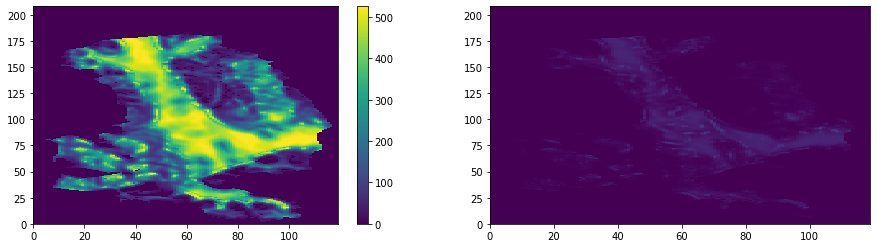

In [27]:
H_smooth = deepcopy(H)
sin_slope_smooth = deepcopy(sin_slope)
for i in range(20):
    sin_slope_smooth = smooth_stress_coupling(H_smooth, sin_slope, mask, 4, 8,2)
    H_smooth =(tau*.5)*1e5/(sin_slope_smooth*9.81*ice_density)

fig, ax = plt.subplots(1,2, figsize=(15,4))
field = ax[0].pcolor(H_smooth*mask)
fig.colorbar(field, ax=ax[0])
T=(2*A*(9.8*ice_density)**3)/5
D=mask*T*H_smooth**5*(slope)**2
field2 = ax[1].pcolor(D, vmax = 1e-1)

In [28]:
ocean_boundary = np.zeros_like(mask_Kr)
for i in range(nx):
    for j in range(ny):
        if mask[j,i] == 0:
            continue
        if np.count_nonzero([item for sublist in (neighbors(retreat_mask, 1, j, i)) for item in sublist])>2:
            if np.count_nonzero([item for sublist in (neighbors(mask_Kr, 1, j, i)) for item in sublist]) > 0:
                ocean_boundary[j,i] = 1

In [29]:
plt.pcolor(ocean_boundary)

In [30]:
### get measured bed elevation in numpy array ###

#find the index that is associated with the radar x-y coordiantes
gr = np.meshgrid(range(119), range(208))
index_y = get_nearest(x,y,gr[1],x_rad, y_rad) 
index_x = get_nearest(x,y,gr[0],x_rad, y_rad)
grid_points = list(zip(index_y, index_x))

# take the mean of all measured thicknesses that fall on one grid point
df_place = pd.DataFrame({"inds":list(zip(index_y, index_x)),"rad":rad[:,0], "x_rad":x_rad[:,0], "y_rad": y_rad[:,0]})
df_place = df_place.groupby('inds').mean()
inds = np.array(df_place.index)
bed_loc = df_place['rad']
x_rad_sample = df_place['x_rad']
radar_mask = np.zeros_like(NPI_DEM)
radar_bed = np.zeros_like(NPI_DEM)
radar_x = np.zeros_like(NPI_DEM)

n = int(len(inds)/2)
random_index = np.random.choice(len(inds), n, replace=False)  

# modify for-statement to sample measured bed elevations according to study question
for i in inds:
    radar_mask[i]=1
    radar_bed[i] = bed_loc[i]
    radar_x[i] = x_rad_sample[i]

In [31]:
### bed recovery ###
S_rec = deepcopy(NPI_DEM)
S_rec[mask==0]=np.nan
S_rec = gauss_filter(S_rec, 1, 3)
S_rec[mask==0]=NPI_DEM[mask==0]
S_init = deepcopy(S_rec)

H_smooth_D = deepcopy(H_smooth)
H_smooth_D[np.logical_and(D>1e-1, ocean_boundary!=1)] = (1e-1/(T*(slope[np.logical_and(D>1e-1, ocean_boundary!=1)])**2))**(1/5)

B_rec = deepcopy(S_rec)
B_rec[mask==1] = np.maximum(S_rec[mask==1]-700, S_rec[mask==1]-H_smooth_D[mask==1])
B_rec[mask==0] = np.nan
B_rec = gauss_filter(B_rec, .6, 3)
B_rec[np.logical_or(B_rec > S_rec, mask==0)]=S_rec[np.logical_or(B_rec > S_rec, mask==0)]
B_rec[retreat_mask==1]=-700

#B_rec[radar_mask == 1] = radar_bed[radar_mask == 1]
    
B_init = deepcopy(B_rec)

dh_ref = deepcopy(dhdt_full)

#tauc_rec = copy(tauc_fit)
#tauc_rec[mask_Kr==1] = tauc[mask_Kr==1]
#tauc_rec[np.isnan(tauc_rec)] = 1e8
tauc_rec = (500+B_init)*1e3

B_rec_all = []
dh_all = []
misfit_all = []
B_misfit_vs_iter=[]
dh_misfit_vs_iter=[]
S_rec_all = []
vel_all = []

pmax = 300
dt = .1
beta = .5
bw = 2

!cp kronebreen_kongsbreen_output.nc kronebreen_kongsbreen_iteration_out.nc
    

original_stdout = sys.stdout
with open('kronebreen_kongsbreen_iteration_script.sh', 'w') as f:
    sys.stdout = f
    create_script('iteration', nx, ny)
    sys.stdout = original_stdout
    f.close()
    
!chmod +x kronebreen_kongsbreen_iteration_script.sh

/tmp/ipykernel_8093/2601049912.py:14: RuntimeWarning: invalid value encountered in true_divide
  Z=VV/WW


In [57]:
taucs_rec = []
taucs_rec.append((500+B_init)*1e3)

In [68]:
taucs_rec.append(tauc_rec)
vel_mismatch = np.minimum((vel / vel_mes),2)
#tauc_rec = (500+B_init)*1e3
tauc_rec[mask==1] *= vel_mismatch.data[mask==1]

In [69]:
for p in tqdm.trange(0, pmax):
    
    h_old = S_rec - B_rec
        
    !cp kronebreen_kongsbreen_iteration_out.nc kronebreen_kongsbreen_iteration_in.nc
    nc_updated = NC('kronebreen_kongsbreen_iteration_in.nc', 'r+')
    nc_updated['topg'][0,:,:]=B_rec
    nc_updated['thk'][0,:,:]=h_old
    nc_updated['tauc'][0,:,:]= tauc_rec
    nc_updated.close()
    
    cmd = ["./kronebreen_kongsbreen_iteration_script.sh", '6', 'kronebreen_kongsbreen_iteration_in.nc', str(dt), 'kronebreen_kongsbreen_iteration_out.nc', str(dt/2)]
    subprocess.call(cmd, stdout=open('kronebreen_kongsbreen_iteration_log.txt', 'a'))
    
    h_rec = get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'thk', 0)
    dh_rec = (h_rec - h_old)/dt
    
    vel = get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'velbar_mag', 0)
    
    u = get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'uvelsurf', 0)
    v = get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'vvelsurf', 0)

    misfit = shift((dh_rec-dh_ref), u, v, 0.3)*mask

    B_rec = B_rec - beta * (misfit)
    #tauc_rec = tauc_rec + beta * misfit * 1e4
    S_rec[np.logical_and(mask==1, h_rec>20)] += (beta*0.05) * misfit[np.logical_and(mask==1, h_rec>20)] 
                
    slope_iter = rd.TerrainAttribute(rd.rdarray(S_rec, no_data=-9999), attrib='slope_riserun')/res
    
    H_rec = S_rec - B_rec
    D_iter = mask*T*H_rec**5*(slope_iter)**2
    H_rec[np.logical_and(D_iter>1e-1, ocean_boundary!=1)] = (1e-1/(T*(slope_iter[np.logical_and(D_iter>1e-1, ocean_boundary!=1)])**2))**(1/5)
    B_rec = S_rec - H_rec
    
    ### fix bed at locations of known ice thickness
    #B_rec[radar_mask == 1] = radar_bed[radar_mask == 1]

    B_rec[B_rec>S_rec]=S_rec[B_rec>S_rec]
    B_rec[B_rec>NPI_DEM]=NPI_DEM[B_rec>NPI_DEM]
    S_rec[mask == 0]= NPI_DEM[mask == 0]
    B_rec[mask == 0]= NPI_DEM[mask == 0]
    
    B_rec_all.append(B_rec)
    dh_all.append(dh_rec)
    misfit[mask==0] = np.nan
    misfit_all.append(misfit)
    S_rec_all.append(S_rec)
    vel_all.append(vel)
    
    B_misfit_vs_iter.append(np.mean(abs(B_rec-B_init)))
    dh_misfit_vs_iter.append(np.mean(abs(dh_rec[mask==1]-dh_ref[mask==1])))

  0%|                                                                                                                                                                                                                | 0/300 [00:00<?, ?it/s]/home/thomas/pism-stable/thick_inv/funcs.py:91: RuntimeWarning: invalid value encountered in sqrt
  uv_mag[np.logical_or(u!=0, v!=0)] = np.sqrt(u[np.logical_or(u!=0, v!=0)]**2+v[np.logical_or(u!=0, v!=0)]**2)

A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006203====================== ] (99% - 0.0s - 1 threads)
  0%|▋                                                                                                                                                                                                       | 1/300 [00:11<57:48, 11.60s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance m

  5%|██████████▌                                                                                                                                                                                            | 16/300 [01:58<28:47,  6.08s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006041


  6%|███████████▎                                                                                                                                                                                           | 17/300 [02:03<28:27,  6.03s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0010895


  6%|███████████▉                                                                                                                                                                                           | 18/300 [02:09<27:51,  5.93s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006233


  6%|████████████▌                                                                                                                                                                                          | 19/300 [02:15<27:33,  5.89s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006033


  7%|█████████████▎                                                                                                                                                                                         | 20/300 [02:21<27:11,  5.83s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006337


  7%|█████████████▉                                                                                                                                                                                         | 21/300 [02:27<27:58,  6.02s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005988


  7%|██████████████▌                                                                                                                                                                                        | 22/300 [02:33<28:14,  6.09s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006145


  8%|███████████████▎                                                                                                                                                                                       | 23/300 [02:40<28:25,  6.16s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006251


  8%|███████████████▉                                                                                                                                                                                       | 24/300 [02:46<28:37,  6.22s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006014


  8%|████████████████▌                                                                                                                                                                                      | 25/300 [02:52<28:47,  6.28s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006066


  9%|█████████████████▏                                                                                                                                                                                     | 26/300 [02:59<29:17,  6.41s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006025


  9%|█████████████████▉                                                                                                                                                                                     | 27/300 [03:06<29:49,  6.56s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006355


  9%|██████████████████▌                                                                                                                                                                                    | 28/300 [03:13<30:10,  6.66s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0010903


 10%|███████████████████▏                                                                                                                                                                                   | 29/300 [03:20<30:17,  6.71s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006192


 10%|███████████████████▉                                                                                                                                                                                   | 30/300 [03:27<30:45,  6.84s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000623


 10%|████████████████████▌                                                                                                                                                                                  | 31/300 [03:34<30:43,  6.85s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006199


 11%|█████████████████████▏                                                                                                                                                                                 | 32/300 [03:41<30:56,  6.93s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006296


 11%|█████████████████████▉                                                                                                                                                                                 | 33/300 [03:48<31:08,  7.00s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006183


 11%|██████████████████████▌                                                                                                                                                                                | 34/300 [03:55<31:22,  7.08s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006902


 12%|███████████████████████▏                                                                                                                                                                               | 35/300 [04:02<30:57,  7.01s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006047


 12%|███████████████████████▉                                                                                                                                                                               | 36/300 [04:10<31:12,  7.09s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0010456


 12%|████████████████████████▌                                                                                                                                                                              | 37/300 [04:16<30:44,  7.01s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006037


 13%|█████████████████████████▏                                                                                                                                                                             | 38/300 [04:23<30:30,  6.99s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006054


 13%|█████████████████████████▊                                                                                                                                                                             | 39/300 [04:30<30:35,  7.03s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006086


 13%|██████████████████████████▌                                                                                                                                                                            | 40/300 [04:37<30:19,  7.00s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005891


 14%|███████████████████████████▏                                                                                                                                                                           | 41/300 [04:44<30:04,  6.97s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005995


 14%|███████████████████████████▊                                                                                                                                                                           | 42/300 [04:52<30:34,  7.11s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0010971


 14%|████████████████████████████▌                                                                                                                                                                          | 43/300 [04:59<30:17,  7.07s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006202


 15%|█████████████████████████████▏                                                                                                                                                                         | 44/300 [05:06<30:08,  7.06s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006016


 15%|█████████████████████████████▊                                                                                                                                                                         | 45/300 [05:13<29:49,  7.02s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006359


 15%|██████████████████████████████▌                                                                                                                                                                        | 46/300 [05:19<29:11,  6.90s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006063


 16%|███████████████████████████████▏                                                                                                                                                                       | 47/300 [05:26<28:20,  6.72s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006178


 16%|███████████████████████████████▊                                                                                                                                                                       | 48/300 [05:32<27:38,  6.58s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005874


 16%|████████████████████████████████▌                                                                                                                                                                      | 49/300 [05:38<26:59,  6.45s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006086


 17%|█████████████████████████████████▏                                                                                                                                                                     | 50/300 [05:44<26:41,  6.41s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006056


 17%|█████████████████████████████████▊                                                                                                                                                                     | 51/300 [05:51<26:46,  6.45s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006139


 17%|██████████████████████████████████▍                                                                                                                                                                    | 52/300 [05:57<26:40,  6.45s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005924


 18%|███████████████████████████████████▏                                                                                                                                                                   | 53/300 [06:04<26:26,  6.42s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005885


 18%|███████████████████████████████████▊                                                                                                                                                                   | 54/300 [06:10<25:44,  6.28s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006034


 18%|████████████████████████████████████▍                                                                                                                                                                  | 55/300 [06:16<25:30,  6.25s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006166


 19%|█████████████████████████████████████▏                                                                                                                                                                 | 56/300 [06:22<25:12,  6.20s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006274


 19%|█████████████████████████████████████▊                                                                                                                                                                 | 57/300 [06:28<24:39,  6.09s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000609


 19%|██████████████████████████████████████▍                                                                                                                                                                | 58/300 [06:33<24:13,  6.01s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000616


 20%|███████████████████████████████████████▏                                                                                                                                                               | 59/300 [06:39<24:01,  5.98s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006031


 20%|███████████████████████████████████████▊                                                                                                                                                               | 60/300 [06:45<23:43,  5.93s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006403


 20%|████████████████████████████████████████▍                                                                                                                                                              | 61/300 [06:51<23:37,  5.93s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006165


 21%|█████████████████████████████████████████▏                                                                                                                                                             | 62/300 [06:57<23:25,  5.90s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006198


 21%|█████████████████████████████████████████▊                                                                                                                                                             | 63/300 [07:03<23:14,  5.88s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005894


 21%|██████████████████████████████████████████▍                                                                                                                                                            | 64/300 [07:09<23:12,  5.90s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006732


 22%|███████████████████████████████████████████                                                                                                                                                            | 65/300 [07:15<23:01,  5.88s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005895


 22%|███████████████████████████████████████████▊                                                                                                                                                           | 66/300 [07:21<23:02,  5.91s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006044


 22%|████████████████████████████████████████████▍                                                                                                                                                          | 67/300 [07:26<22:49,  5.88s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006066


 23%|█████████████████████████████████████████████                                                                                                                                                          | 68/300 [07:32<22:58,  5.94s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006501


 23%|█████████████████████████████████████████████▊                                                                                                                                                         | 69/300 [07:38<22:54,  5.95s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000603


 23%|██████████████████████████████████████████████▍                                                                                                                                                        | 70/300 [07:45<23:04,  6.02s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006146


 24%|███████████████████████████████████████████████                                                                                                                                                        | 71/300 [07:51<22:54,  6.00s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006085


 24%|███████████████████████████████████████████████▊                                                                                                                                                       | 72/300 [07:57<22:48,  6.00s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006353


 24%|████████████████████████████████████████████████▍                                                                                                                                                      | 73/300 [08:03<22:58,  6.07s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006148


 25%|█████████████████████████████████████████████████                                                                                                                                                      | 74/300 [08:09<22:34,  6.00s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006608


 25%|█████████████████████████████████████████████████▊                                                                                                                                                     | 75/300 [08:15<22:39,  6.04s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0010616


 25%|██████████████████████████████████████████████████▍                                                                                                                                                    | 76/300 [08:21<22:37,  6.06s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005904


 26%|███████████████████████████████████████████████████                                                                                                                                                    | 77/300 [08:27<22:32,  6.07s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006046


 26%|███████████████████████████████████████████████████▋                                                                                                                                                   | 78/300 [08:33<22:25,  6.06s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006018


 26%|████████████████████████████████████████████████████▍                                                                                                                                                  | 79/300 [08:39<22:20,  6.07s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006057


 27%|█████████████████████████████████████████████████████                                                                                                                                                  | 80/300 [08:45<22:21,  6.10s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006338


 27%|█████████████████████████████████████████████████████▋                                                                                                                                                 | 81/300 [08:51<22:19,  6.12s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006111


 27%|██████████████████████████████████████████████████████▍                                                                                                                                                | 82/300 [08:58<22:34,  6.21s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006012


 28%|███████████████████████████████████████████████████████                                                                                                                                                | 83/300 [09:04<22:39,  6.27s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000605


 28%|███████████████████████████████████████████████████████▋                                                                                                                                               | 84/300 [09:11<22:48,  6.33s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000615


 28%|████████████████████████████████████████████████████████▍                                                                                                                                              | 85/300 [09:17<22:36,  6.31s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006044


 29%|█████████████████████████████████████████████████████████                                                                                                                                              | 86/300 [09:23<22:28,  6.30s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006241


 29%|█████████████████████████████████████████████████████████▋                                                                                                                                             | 87/300 [09:30<22:44,  6.41s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006144


 29%|██████████████████████████████████████████████████████████▎                                                                                                                                            | 88/300 [09:36<22:38,  6.41s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006032


 30%|███████████████████████████████████████████████████████████                                                                                                                                            | 89/300 [09:42<22:16,  6.34s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005919


 30%|███████████████████████████████████████████████████████████▋                                                                                                                                           | 90/300 [09:49<22:37,  6.47s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006399


 30%|████████████████████████████████████████████████████████████▎                                                                                                                                          | 91/300 [09:56<22:31,  6.47s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006333


 31%|█████████████████████████████████████████████████████████████                                                                                                                                          | 92/300 [10:02<22:37,  6.52s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006292


 31%|█████████████████████████████████████████████████████████████▋                                                                                                                                         | 93/300 [10:09<22:54,  6.64s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006117


 31%|██████████████████████████████████████████████████████████████▎                                                                                                                                        | 94/300 [10:16<22:36,  6.58s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006014


 32%|███████████████████████████████████████████████████████████████                                                                                                                                        | 95/300 [10:22<22:09,  6.48s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006161


 32%|███████████████████████████████████████████████████████████████▋                                                                                                                                       | 96/300 [10:28<21:50,  6.43s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000619


 32%|████████████████████████████████████████████████████████████████▎                                                                                                                                      | 97/300 [10:35<21:39,  6.40s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006103


 33%|█████████████████████████████████████████████████████████████████                                                                                                                                      | 98/300 [10:41<21:35,  6.41s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006209


 33%|█████████████████████████████████████████████████████████████████▋                                                                                                                                     | 99/300 [10:48<21:36,  6.45s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005928


 33%|██████████████████████████████████████████████████████████████████                                                                                                                                    | 100/300 [10:54<21:29,  6.45s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006182


 34%|██████████████████████████████████████████████████████████████████▋                                                                                                                                   | 101/300 [11:01<21:34,  6.50s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006302


 34%|███████████████████████████████████████████████████████████████████▎                                                                                                                                  | 102/300 [11:07<21:27,  6.50s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006182


 34%|███████████████████████████████████████████████████████████████████▉                                                                                                                                  | 103/300 [11:14<21:26,  6.53s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006132


 35%|████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 104/300 [11:20<21:26,  6.56s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006055


 35%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                | 105/300 [11:27<21:40,  6.67s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006168


 35%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                | 106/300 [11:34<21:23,  6.61s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006198


 36%|██████████████████████████████████████████████████████████████████████▌                                                                                                                               | 107/300 [11:41<21:42,  6.75s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006203


 36%|███████████████████████████████████████████████████████████████████████▎                                                                                                                              | 108/300 [11:48<21:46,  6.80s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006301


 36%|███████████████████████████████████████████████████████████████████████▉                                                                                                                              | 109/300 [11:55<21:39,  6.80s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005928


 37%|████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 110/300 [12:01<21:28,  6.78s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006035


 37%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 111/300 [12:08<21:26,  6.80s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006042


 37%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 112/300 [12:15<21:16,  6.79s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006168


 38%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 113/300 [12:22<21:35,  6.93s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006035


 38%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 114/300 [12:29<21:34,  6.96s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006327


 38%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 115/300 [12:37<22:12,  7.20s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000616


 39%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 116/300 [12:44<22:02,  7.19s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006038


 39%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 117/300 [12:52<22:24,  7.35s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006024


 39%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 118/300 [12:59<21:59,  7.25s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005895


 40%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 119/300 [13:07<22:13,  7.37s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005982


 40%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 120/300 [13:14<22:17,  7.43s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006662


 40%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 121/300 [13:22<22:24,  7.51s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000634


 41%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 122/300 [13:29<22:24,  7.55s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006426


 41%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 123/300 [13:38<22:46,  7.72s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006177


 41%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 124/300 [13:45<22:13,  7.58s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006184


 42%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 125/300 [13:53<22:27,  7.70s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006053


 42%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 126/300 [14:00<22:17,  7.69s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006418


 42%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 127/300 [14:08<22:11,  7.69s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005919


 43%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 128/300 [14:16<21:56,  7.65s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006022


 43%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 129/300 [14:23<21:43,  7.62s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006173


 43%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 130/300 [14:31<21:18,  7.52s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006188


 44%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 131/300 [14:38<20:51,  7.40s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000605


 44%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 132/300 [14:45<20:33,  7.34s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006476


 44%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 133/300 [14:52<19:55,  7.16s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006039


 45%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 134/300 [14:59<19:56,  7.20s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006018


 45%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 135/300 [15:06<19:51,  7.22s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006374


 45%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 136/300 [15:14<20:02,  7.33s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006639


 46%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 137/300 [15:21<19:42,  7.26s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005931


 46%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 138/300 [15:28<19:12,  7.11s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006056


 46%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 139/300 [15:34<18:53,  7.04s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006044


 47%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 140/300 [15:42<18:48,  7.06s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006804


 47%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 141/300 [15:49<18:44,  7.07s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006199


 47%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 142/300 [15:56<18:56,  7.19s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006025


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 143/300 [16:03<18:38,  7.12s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006232


 48%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 144/300 [16:10<18:20,  7.06s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006235


 48%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 145/300 [16:17<18:08,  7.02s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006044


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 146/300 [16:24<18:09,  7.07s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006226


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 147/300 [16:31<18:13,  7.15s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006002


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 148/300 [16:39<18:19,  7.23s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006197


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 149/300 [16:46<17:48,  7.08s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000602


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 150/300 [16:53<18:02,  7.22s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006014


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 151/300 [17:00<17:57,  7.23s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006327


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 152/300 [17:08<17:44,  7.19s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006241


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 153/300 [17:15<18:01,  7.36s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006302


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 154/300 [17:22<17:33,  7.22s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005907


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 155/300 [17:30<17:39,  7.31s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006077


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 156/300 [17:38<17:58,  7.49s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006878


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 157/300 [17:45<17:42,  7.43s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000604


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 158/300 [17:52<17:40,  7.47s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006172


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 159/300 [18:00<17:30,  7.45s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006152


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 160/300 [18:07<17:19,  7.43s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006066


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 161/300 [18:15<17:15,  7.45s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006218


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 162/300 [18:22<17:07,  7.44s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006787


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 163/300 [18:30<17:00,  7.45s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.00059


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 164/300 [18:37<16:50,  7.43s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006263


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 165/300 [18:44<16:39,  7.40s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006183


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 166/300 [18:52<16:51,  7.55s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006064


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 167/300 [18:59<16:27,  7.43s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006254


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 168/300 [19:07<16:26,  7.47s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006194


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 169/300 [19:15<16:28,  7.55s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006187


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 170/300 [19:22<16:10,  7.47s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005929


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 171/300 [19:29<15:55,  7.40s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006244


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 172/300 [19:37<15:48,  7.41s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006279


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 173/300 [19:44<15:49,  7.47s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006511


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 174/300 [19:52<15:41,  7.47s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006115


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 175/300 [19:59<15:28,  7.43s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006028


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 176/300 [20:07<15:43,  7.61s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000654


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 177/300 [20:15<15:40,  7.65s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006145


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 178/300 [20:22<15:23,  7.57s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006034


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 179/300 [20:29<14:51,  7.37s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006143


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 180/300 [20:37<14:53,  7.44s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.001126


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 181/300 [20:44<14:32,  7.34s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006118


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 182/300 [20:51<14:18,  7.27s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0010766


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 183/300 [20:58<14:14,  7.30s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006221


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 184/300 [21:05<13:58,  7.23s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000601


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 185/300 [21:12<13:46,  7.19s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006201


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 186/300 [21:20<13:45,  7.24s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006041


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 187/300 [21:27<13:38,  7.25s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006215


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 188/300 [21:34<13:29,  7.23s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006176


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 189/300 [21:42<13:30,  7.30s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006071


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 190/300 [21:50<13:38,  7.44s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006326


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 191/300 [21:57<13:24,  7.38s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006027


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 192/300 [22:04<13:11,  7.33s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000617


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 193/300 [22:11<12:57,  7.26s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006034


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 194/300 [22:18<12:46,  7.23s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006029


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 195/300 [22:26<12:42,  7.26s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006165


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 196/300 [22:33<12:33,  7.24s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006212


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 197/300 [22:41<12:46,  7.45s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006047


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 198/300 [22:48<12:33,  7.39s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005905


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 199/300 [22:55<12:26,  7.39s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006041


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 200/300 [23:03<12:20,  7.40s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005915


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 201/300 [23:10<12:10,  7.38s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000591


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 202/300 [23:17<11:57,  7.32s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006008


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 203/300 [23:24<11:40,  7.22s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006139


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 204/300 [23:32<11:41,  7.30s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005967


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 205/300 [23:39<11:31,  7.28s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000607


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 206/300 [23:46<11:28,  7.32s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000592


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 207/300 [23:54<11:14,  7.26s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005916


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 208/300 [24:01<11:05,  7.23s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006169


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 209/300 [24:08<11:09,  7.36s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006203


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 210/300 [24:16<11:01,  7.35s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006222


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 211/300 [24:23<11:00,  7.42s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006154


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 212/300 [24:31<11:03,  7.54s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006054


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 213/300 [24:39<10:59,  7.58s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006032


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 214/300 [24:47<10:59,  7.67s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005918


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 215/300 [24:54<10:54,  7.70s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006587


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 216/300 [25:03<10:57,  7.83s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006031


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 217/300 [25:10<10:40,  7.72s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000618


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 218/300 [25:18<10:36,  7.76s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006348


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 219/300 [25:25<10:24,  7.71s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006071


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 220/300 [25:33<10:16,  7.70s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006158


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 221/300 [25:41<10:07,  7.69s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006628


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 222/300 [25:49<10:10,  7.83s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006211


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 223/300 [25:57<09:58,  7.77s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006334


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 224/300 [26:05<10:02,  7.92s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006171


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 225/300 [26:12<09:41,  7.75s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006191


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 226/300 [26:20<09:42,  7.88s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0010876


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 227/300 [26:28<09:23,  7.71s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006073


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 228/300 [26:36<09:32,  7.96s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006113


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 229/300 [26:44<09:18,  7.87s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000604


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 230/300 [26:52<09:21,  8.02s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006199


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 231/300 [27:00<09:01,  7.84s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006221


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 232/300 [27:08<08:58,  7.92s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006062


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 233/300 [27:16<08:52,  7.95s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000618


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 234/300 [27:24<08:46,  7.98s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006265


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 235/300 [27:31<08:29,  7.84s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006027


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 236/300 [27:39<08:25,  7.89s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0010854


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 237/300 [27:47<08:13,  7.83s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006233


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 238/300 [27:56<08:20,  8.06s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006019


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 239/300 [28:04<08:12,  8.08s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006078


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 240/300 [28:12<08:05,  8.09s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005901


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 241/300 [28:20<07:50,  7.97s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006065


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 242/300 [28:28<07:54,  8.17s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006033


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 243/300 [28:36<07:41,  8.10s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006181


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 244/300 [28:44<07:34,  8.12s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006642


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 245/300 [28:52<07:23,  8.07s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006067


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 246/300 [29:01<07:28,  8.30s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006204


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 247/300 [29:08<07:04,  8.01s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006219


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 248/300 [29:17<07:05,  8.19s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006043


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 249/300 [29:25<06:51,  8.08s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006315


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 250/300 [29:33<06:43,  8.07s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0010627


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 251/300 [29:41<06:31,  7.98s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006047


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 252/300 [29:49<06:32,  8.18s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006041


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 253/300 [29:57<06:18,  8.05s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005915


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 254/300 [30:06<06:23,  8.34s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006125


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 255/300 [30:14<06:10,  8.23s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006273


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 256/300 [30:23<06:05,  8.32s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006038


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 257/300 [30:30<05:48,  8.11s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000603


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 258/300 [30:39<05:54,  8.44s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.00065


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 259/300 [30:47<05:39,  8.28s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006061


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 260/300 [30:56<05:38,  8.45s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006085


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 261/300 [31:04<05:24,  8.32s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006171


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 262/300 [31:13<05:25,  8.57s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000649


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 263/300 [31:21<05:06,  8.29s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006491


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 264/300 [31:30<05:06,  8.52s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005884


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 265/300 [31:38<04:55,  8.43s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000602


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 266/300 [31:47<04:48,  8.50s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005961


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 267/300 [31:55<04:38,  8.43s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006195


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 268/300 [32:05<04:40,  8.77s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006155


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 269/300 [32:13<04:29,  8.68s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005913


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 270/300 [32:22<04:24,  8.82s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006021


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 271/300 [32:31<04:15,  8.80s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006863


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 272/300 [32:41<04:12,  9.01s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006023


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 273/300 [32:49<03:58,  8.83s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006032


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 274/300 [32:58<03:53,  8.97s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006062


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 275/300 [33:06<03:37,  8.70s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0012975


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 276/300 [33:16<03:32,  8.87s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006039


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 277/300 [33:24<03:21,  8.77s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006316


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 278/300 [33:33<03:14,  8.83s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006281


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 279/300 [33:43<03:11,  9.14s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000632


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 280/300 [33:55<03:19,  9.97s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006926


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 281/300 [34:05<03:12, 10.12s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006627


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 282/300 [34:18<03:13, 10.74s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006025


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 283/300 [34:27<02:53, 10.22s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006333


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 284/300 [34:36<02:39,  9.97s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006539


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 285/300 [34:45<02:23,  9.55s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006148


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 286/300 [34:54<02:12,  9.47s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006275


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 287/300 [35:02<01:59,  9.17s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006165


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 288/300 [35:12<01:51,  9.33s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006309


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 289/300 [35:21<01:41,  9.23s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006144


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 290/300 [35:31<01:34,  9.45s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006194


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 291/300 [35:39<01:22,  9.16s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006011


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 292/300 [35:49<01:14,  9.26s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006509


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 293/300 [35:57<01:02,  8.96s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006032


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 294/300 [36:07<00:54,  9.13s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006049


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 295/300 [36:15<00:44,  8.89s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006155


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 296/300 [36:24<00:35,  8.96s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0005991


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 297/300 [36:33<00:26,  8.86s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006423


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 298/300 [36:42<00:18,  9.05s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006163


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 299/300 [36:51<00:09,  9.05s/it]
A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0006287


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [37:01<00:00,  7.40s/it]


In [70]:
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(B_rec_all))]
fig, axes = plt.subplots(1,2, figsize=(15,5))
field = axes[0].pcolor(S_rec - B_rec)#, vmin=0, vmax=2, cmap='RdBu')
fig.colorbar(field, ax=axes[0])
for i in range(0,len(B_rec_all),1):
    lines = axes[1].plot(range(nx), B_rec_all[i][40,:], color=colors[i])
lines2 = axes[1].plot(range(nx), NPI_DEM[40,:])
lines2 = axes[1].plot(range(nx), B_init[40,:])
lines2 = axes[1].plot(range(nx), S_rec[40,:], color='r')
axes[1].set_ylim([-700,900])

(-700, 900)

In [121]:
rad_msk = radar_mask[3:-3,3:-3]
rad_msk_nan = copy(rad_msk)
rad_msk_nan[rad_msk==0] = np.nan

#H = get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'thk', 0)[1:-1,1:-1]
h = gauss_filter(NPI_DEM, 1, 3)
H = np.zeros_like(h)
H[radar_mask==1] = h[radar_mask==1] - radar_bed[radar_mask==1]

x_d = np.transpose(np.where(radar_mask==1))
grid_x, grid_y = np.meshgrid(range(np.shape(radar_mask)[1]), range(np.shape(radar_mask)[0]))
rad_bed_int = griddata(x_d, (radar_bed)[radar_mask==1], (grid_y, grid_x), method='nearest')
H_int = h - rad_bed_int
#H_int = gauss_filter(H_int, 1, 3)

dhdx = -(h[1:-1,1:-1] - h[1:-1,0:-2])/res
dhdy = -(h[1:-1,1:-1] - h[0:-2,1:-1])/res

alpha = (np.sqrt(dhdx**2+dhdy**2))
SIA_u = (9.8*ice_density)**3*(dhdx)**3*-0.5*A*H_int[1:-1,1:-1]**4
SIA_v = (9.8*ice_density)**3*(dhdy)**3*-0.5*A*H_int[1:-1,1:-1]**4
SIA_vel = np.sqrt(SIA_u**2+SIA_v**2)

u = get_nc_data('./models/Kronebreen_40c15bbcc113c6a863b5eee02faf9ecc715d6743.nc', 'uvelsurf', 0)
v = get_nc_data('./models/Kronebreen_40c15bbcc113c6a863b5eee02faf9ecc715d6743.nc', 'vvelsurf', 0)

SSA_u = u[1:-1, 1:-1]/secpera - SIA_u
SSA_v = v[1:-1, 1:-1]/secpera - SIA_v
SSA_vel = np.sqrt(SSA_u**2+SSA_v**2)

SSA_u_mod = get_nc_data('./models/Kronebreen_40c15bbcc113c6a863b5eee02faf9ecc715d6743.nc', 'u_ssa', 0)[1:-1,1:-1]
SSA_v_mod = get_nc_data('./models/Kronebreen_40c15bbcc113c6a863b5eee02faf9ecc715d6743.nc', 'v_ssa', 0)[1:-1,1:-1]
SSA_vel_mod = np.sqrt(SSA_u_mod**2 + SSA_v_mod**2)

dudx = -(SSA_u_mod[1:-1,1:-1] - SSA_u_mod[1:-1,0:-2])/res
dudy = -(SSA_u_mod[1:-1,1:-1] - SSA_u_mod[0:-2,1:-1])/res
dvdx = -(SSA_v_mod[1:-1,1:-1] - SSA_v_mod[1:-1, 0:-2])/res
dvdy = -(SSA_v_mod[1:-1,1:-1] - SSA_v_mod[0:-2,1:-1])/res

exx = -(u[1:-1,1:-1] - u[1:-1,0:-2])/res
exy = -(u[1:-1,1:-1] - u[0:-2,1:-1])/res
eyx = -(v[1:-1,1:-1] - v[1:-1,0:-2])/res
eyy = -(v[1:-1,1:-1] - v[0:-2,1:-1])/res

#e_xy = 0.5*(dudy+dvdx)
B = A**(-1/3)
v_eff = 0.5*B*(exx**2+eyy**2+exx*eyy+0.25*(eyx+exy)**2)**(1/3)

s1 = 2*v_eff[1:-1,1:-1]*H_int[2:-2,2:-2]*(2*dudx+dvdy)
s2 = v_eff[1:-1,1:-1]*H_int[2:-2,2:-2]*(dudy+dvdx)

s3 = v_eff[1:-1,1:-1]*H_int[2:-2,2:-2]*(dudy+dvdx)
s4 = 2*v_eff[1:-1,1:-1]*H_int[2:-2,2:-2]*(dudx+2*dvdy)

t1 = -(s1[1:-1,1:-1] - s1[1:-1,0:-2])/res
t2 = -(s2[1:-1,1:-1] - s2[0:-2,1:-1])/res

t3 = -(s3[1:-1,1:-1] - s3[1:-1,0:-2])/res
t4 = -(s4[1:-1,1:-1] - s2[0:-2,1:-1])/res

taud_x = ice_density*9.8*H_int[3:-3,3:-3]*np.sin(np.arctan(dhdx[2:-2,2:-2]))
taud_y = ice_density*9.8*H_int[3:-3,3:-3]*np.sin(np.arctan(dhdy[2:-2,2:-2]))

tau_d = get_nc_data('./models/Kronebreen_40c15bbcc113c6a863b5eee02faf9ecc715d6743.nc', 'taud_mag', 0)[3:-3,3:-3]
tau_b = get_nc_data('./models/Kronebreen_40c15bbcc113c6a863b5eee02faf9ecc715d6743.nc', 'taub_mag', 0)[3:-3,3:-3]

taub_x = taud_x-t1-t2
taub_y = taud_y - t3 - t4
taub_cal = np.sqrt(taub_x**2+taub_y**2)

tauc_cal = -taub_cal/(SSA_vel[2:-2,2:-2]*secpera)*3.1556926e7**.2*abs(SSA_vel[2:-2,2:-2]*secpera)**(1-0.2)

tauc_x = -taub_x/(SSA_u_mod[2:-2,2:-2]*secpera)*3.1556926e7**.2*abs(SSA_vel[2:-2,2:-2]*secpera)**(1-0.2)
tauc_y = -taub_y/(SSA_v_mod[2:-2,2:-2]*secpera)*3.1556926e7**.2*abs(SSA_vel[2:-2,2:-2]*secpera)**(1-0.2)
tauc_xy = np.sqrt(tauc_x**2+tauc_y**2)
tauc_xy_s = gauss_filter(tauc_xy, 1, 3)

tauc = griddata(x_d, tauc_xy[rad_msk==1], (grid_y, grid_x), method='nearest')
tauc = gauss_filter(tauc, 1, 3)

/tmp/ipykernel_8093/3455584684.py:29: RuntimeWarning: invalid value encountered in sqrt
  SSA_vel = np.sqrt(SSA_u**2+SSA_v**2)
/tmp/ipykernel_8093/3455584684.py:69: RuntimeWarning: invalid value encountered in sqrt
  taub_cal = np.sqrt(taub_x**2+taub_y**2)
/tmp/ipykernel_8093/3455584684.py:75: RuntimeWarning: invalid value encountered in sqrt
  tauc_xy = np.sqrt(tauc_x**2+tauc_y**2)
/tmp/ipykernel_8093/2601049912.py:14: RuntimeWarning: invalid value encountered in true_divide
  Z=VV/WW


In [29]:
### filter outliers in tauc_fil ###
tauc_fil = tauc[3:-3,3:-3]
tauc_new = np.zeros_like(tauc_fil)
for i in range(np.shape(tauc_fil)[0]):
    for j in range(np.shape(tauc_fil)[1]):
        if rad_msk[i, j]==0:
                tauc_new[i, j] = 0
        else:
            y_f, x_f = np.ogrid[:np.shape(tauc_fil)[0], :np.shape(tauc_fil)[1]]
            circle = (y_f - i) ** 2 + (x_f - j) ** 2 <= 20
            local_med = np.median(tauc_fil[np.logical_and(circle, rad_msk==1)])
            local_std = np.std(tauc_fil[np.logical_and(circle, rad_msk==1)])
            if tauc_fil[i,j] >  local_med + 1* local_std:
                tauc_new[i, j]= local_med + 1* local_std
            elif tauc_fil[i,j] < local_med - 1* local_std:
                tauc_new[i, j]= local_med - 1* local_std              
            else:
                tauc_new[i,j] = tauc_fil[i,j]

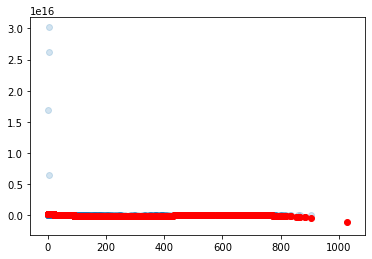

In [46]:
vel_t = copy(vel_mes)
#vel_t[vel_t.mask]=0
tauc_clean = tauc_new
tauc_clean[np.isnan(tauc_clean)]=0
poly_tauc = np.poly1d(np.polyfit(vel_t[3:-3,3:-3][rad_msk==1],tauc_clean[rad_msk==1],3))
tauc_fit = poly_tauc(vel_t)

plt.scatter(vel_t[3:-3,3:-3][rad_msk==1],tauc_clean[rad_msk==1], alpha =.2)
plt.scatter(vel_t, tauc_fit, c='r')
#plt.ylim([-1e7, 3e7])

In [27]:
tauc_ref = (500+B_init[3:-3,3:-3])*1e3*rad_msk_nan

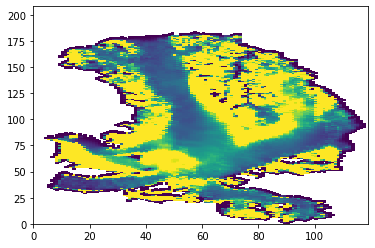

In [29]:
plt.pcolor((vel - vel_mes)/vel_mes, vmin = -1, vmax = 1)

In [123]:
tauc_ref = tauc_rec[3:-3,3:-3]

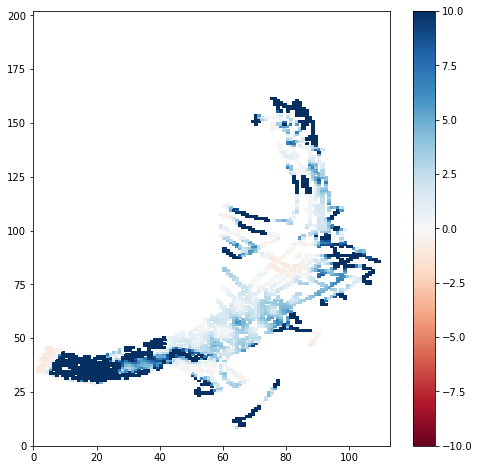

In [124]:
fig, ax = plt.subplots(figsize=(8,8))
field = ax.pcolor((tauc[3:-3,3:-3]*rad_msk_nan-tauc_ref)/(tauc_ref), vmax = 10, vmin = -10, cmap = 'RdBu')
fig.colorbar(field, ax = ax)

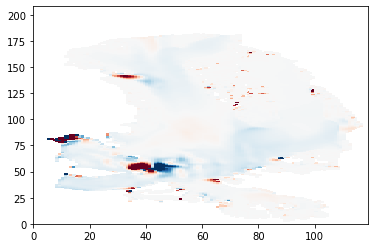

In [71]:
plt.pcolor(misfit_all[-1], cmap='RdBu', vmin=-1, vmax=1)

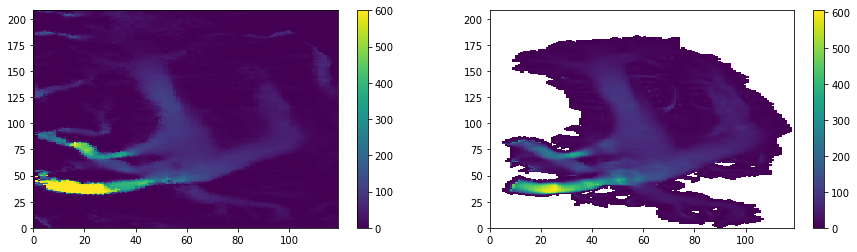

In [129]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
field = ax[0].pcolor(vel_mes, vmax = 600)
field1 = ax[1].pcolor(vel)
fig.colorbar(field, ax = ax[0])
fig.colorbar(field1, ax = ax[1])

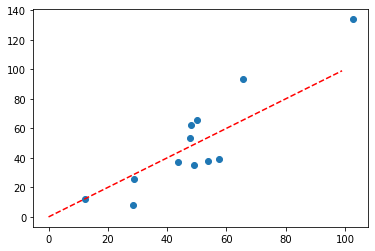

In [126]:
fig, ax = plt.subplots()
points = ax.scatter(vel_0914, get_nearest(x,y,vel_mes, vel_x, vel_y))
#points = ax.scatter((SSA_vel[2:-2,2:-2]+SIA_vel[2:-2,2:-2])*rad_msk_nan*secpera, vel[3:-3,3:-3]*rad_msk_nan)
line = ax.plot(range(100), range(100), '--',c='r')
#plt.xlim([0,1000])

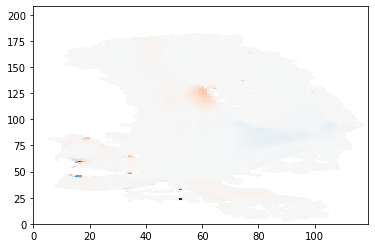

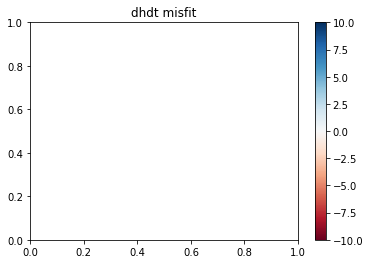

In [45]:
from IPython.display import display, clear_output #needed for animated plots

fig, axes = plt.subplots()
for i in range(0,len(B_rec_all),20):
    field = axes.pcolor(misfit_all[i], cmap='RdBu', vmin=-10, vmax=10)
    #field = axes.pcolor(S_rec_all[i]-B_rec_all[i], vmax=800, vmin=0)
    clear_output(wait=True)
    display(fig)
    axes.cla()
axes.set_title('dhdt misfit')
fig.colorbar(field)

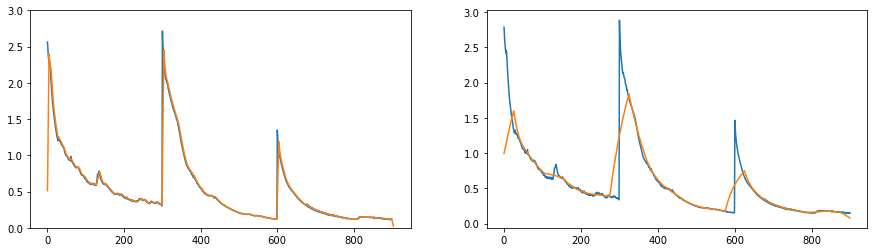

In [73]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
line = ax[0].plot(np.nanmean(abs(np.array(misfit_all)), axis=(1,2)))
line = ax[0].plot(np.convolve(np.nanmean(abs(np.array(misfit_all)), axis=(1,2)), np.ones(5)/5))
ax[0].set_ylim([0,3])
line2 = ax[1].plot(dh_misfit_vs_iter)
line1 = ax[1].plot(np.convolve(dh_misfit_vs_iter, np.ones(50)/50, mode='same'))

In [74]:
Z_at_rad = get_nearest(x[mask==1],y[mask==1],NPI_DEM[mask==1], x_rad, y_rad)

df = pd.DataFrame({"Z":Z_at_rad,"rad":rad[:,0], "x_rad":x_rad[:,0], "y_rad": y_rad[:,0]})
df = df.groupby('Z').mean()

df_sample = copy(df)
#for q,i in enumerate(df['x_rad']):
#    if i in radar_x:
#        df_sample = df_sample.drop(df.index[q])

thick_ref_at_rad = df_sample.index - df_sample['rad']
thick_rec = S_rec - B_rec
thick_rec_at_rad = get_nearest(x[mask==1], y[mask==1], thick_rec[mask==1], np.array(df_sample['x_rad']), np.array(df_sample['y_rad']))

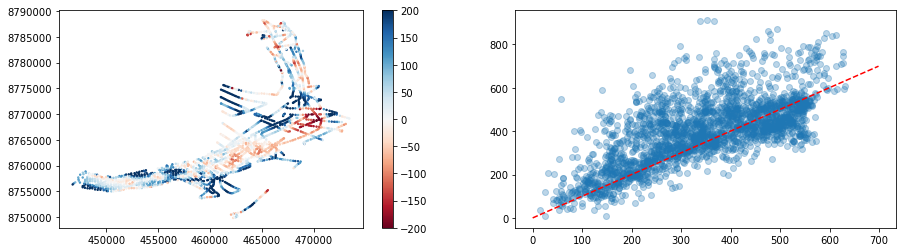

In [75]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
field = ax[0].scatter(np.array(df_sample['x_rad']), np.array(df_sample['y_rad']), c=(thick_rec_at_rad - thick_ref_at_rad), cmap='RdBu', s=2, vmin=-200, vmax=200)
fig.colorbar(field, ax = ax[0])

scatter = ax[1].scatter(thick_ref_at_rad, thick_rec_at_rad, marker='o', alpha=.3)
line = ax[1].plot(range(700), range(700), '--', c='r')

In [ ]:
data_at_rad = get_nearest(x,y,get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'topg', 0), np.array(df['x_rad']), np.array(df['y_rad']))
#data_at_rad = get_nearest(x,y, B_rec, np.array(df['x_rad']), np.array(df['y_rad']))
fig, ax = plt.subplots(1,2, figsize=(15,4))
points = ax[0].scatter(data_at_rad, (thick_rec_at_rad - thick_ref_at_rad), alpha=.3)
points1 = ax[1].scatter(B_rec, (500+np.maximum(0, B_init))*1e5)

In [76]:
import scipy.stats as st
#max_cor_ind = int(np.where(cors==np.max(cors))[0])
dev = (thick_rec_at_rad - thick_ref_at_rad)/np.mean(thick_ref_at_rad)
mean_dev = np.nanmean((dev))
mean_abs_dev = np.nanmean(abs(thick_rec_at_rad - thick_ref_at_rad))
med_dev = np.nanmedian((dev))
IQR_dev = np.nanpercentile(dev, 75) - np.nanpercentile(dev, 25)
conf_dev = mean_dev-st.t.interval(0.95, len(dev)-1, loc=np.nanmean(dev), scale=st.sem(dev[~np.isnan(dev)]))
RMSE = math.sqrt(mean_squared_error(thick_ref_at_rad, thick_rec_at_rad))
print('RMSE: {} m'.format(RMSE))
print('mean deviation: {} %'.format(mean_dev))
print('mean absolute deviation: {} m'.format(mean_abs_dev))
print('median deviation: {} %'.format(med_dev))
print('Interquartile range of deviation: {}'.format(IQR_dev))
print('95% confidence intervall: {}'.format(conf_dev))

In [ ]:
import gdal

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def write_geotiff(array, geoinfo):
    dst_filename = '{}.tiff'.format(namestr(array, globals())[0])
    y_pixels, x_pixels = np.shape(array)  # number of pixels in x

    driver = gdal.GetDriverByName('GTiff')
    dataset = driver.Create(dst_filename,x_pixels, y_pixels, 1,gdal.GDT_Float32)
    dataset.GetRasterBand(1).WriteArray(np.flip(array, axis=0))

    # follow code is adding GeoTranform and Projection
    #geotrans=geoinfo.GetGeoTransform()  #get GeoTranform from existed 'data0'
    #proj=geoinfo.GetProjection() #you can get from a exsited tif or import 
    #dataset.SetGeoTransform(geotrans)
    #dataset.SetProjection(proj)
    #dataset.FlushCache()
    

In [ ]:
write_geotiff(Z_mean, 1)

In [ ]:
blo_org = np.zeros((9,9))
blo_org[4,4] = 1
#blo[5,4] = 1
blo = ndimage.gaussian_filter(blo_org, .7, truncate=3)
fig, ax = plt.subplots()
field = ax.pcolor(blo_org - blo)
fig.colorbar(field, ax = ax)
#print(np.max(blo-ndimage.gaussian_filter(blo, .3, 4)))

In [ ]:
    ## save output    
    import shelve
    bk = shelve.open('./KK_it300_beta.5_dt.1_tauc500Binit1e3_q.2_likebetterocean_startthin','n')
    for k in dir():
        if k in ['NPI_50m_DEM', 'NPI_DEM', 'NPI_DEM_o', 'R2_50m_Vel', 'R2_50m_Vx', 'R2_50m_Vy', 'R2_Vel', 'R2_Vx', 'R2_Vy', 'Z_09', 'Z_14', 'Z_50m_09', 'Z_50m_14', 'Z_50m_20', 'Z_50m_90', 'bed', 'bed_mask', 'bed_mask_meta', 'bed_o', 'dhdt_0914', 'dhdt_50m_0914', 'mat_DEM_Vel', 'mat_RADAR', 'ocean_50m_mask', 'retreat_50m_mask','smb_50m_fit', 'smb_fit', 'smb_net_0914', 'smb_net_df', 'smb_x', 'smb_y', 'smb_z', 'smb_xyz_df', 'surf', 'surf_mask','surf_mask_meta', 'surf_o', 'thk', 'thk_mask', 'thk_mask_meta', 'thk_o', 'vel_0914', 'vel_50m_0914', 'vel_df', 'vel_x', 'vel_y', 'vel_z', 'vel_xyz_df', 'x_50m', 'y_50m']:
            continue
        if k.split('_')[0]=='':
            continue
        try:
            bk[k] = globals()[k]
        except Exception:
            print('{} was not saved'.format(k))
            pass
    bk.close()

In [ ]:
save_and_commit('Kronebreen-Kongsbreen.ipynb', 'Kronebreen', 'kronebreen_kongsbreen_iteration_out.nc', 'twice updating friction based on velocities. Looks good!')

In [130]:
def save_and_commit(notebook_path, branch_name, nc_file, commit_message):
    
    current_branch = subprocess.check_output(["git", "rev-parse", "--abbrev-ref", "HEAD"]).decode('ascii').strip()
    if current_branch != branch_name:
        raise ValueError('not on correct branch')
        
    if (os.path.exists(nc_file) and os.path.exists('./models/') and os.path.exists('./data/')) == False:
        raise ValueError('nc_file or target folder does not exist')
    
    start_md5 = hashlib.md5(open(notebook_path,'rb').read()).hexdigest()
    display(Javascript('IPython.notebook.save_checkpoint();'))
    current_md5 = start_md5
        
    while start_md5 == current_md5:
        time.sleep(1)
        current_md5 = hashlib.md5(open(notebook_path,'rb').read()).hexdigest()
                
    stage = ["git", "add", "{}".format(notebook_path)]
    commit = ["git", "commit", "-m", commit_message]
    try:
        proc = subprocess.check_output(stage, stderr=subprocess.STDOUT)
        proc = subprocess.check_output(commit, stderr=subprocess.STDOUT)
    except subprocess.CalledProcessError:
        raise ValueError('something went wrong')
        
    hashmark =  subprocess.check_output(['git', 'rev-parse', 'HEAD']).decode('ascii').strip()
    save_model = ["cp", "{}".format(nc_file), "./models/{}_{}.nc".format(branch_name, hashmark)]
    proc = subprocess.check_output(save_model, stderr=subprocess.STDOUT)

    bk = shelve.open('./data/{}_{}.pkl'.format(branch_name, hashmark),'n')
    exceptions = ['NPI_50m_DEM', 'NPI_DEM', 'NPI_DEM_o', 'R2_50m_Vel', 'R2_50m_Vx', 'R2_50m_Vy', 'R2_Vel', 'R2_Vx', 'R2_Vy', 'Z_09', 'Z_14', 'Z_50m_09', 'Z_50m_14', 'Z_50m_20', 'Z_50m_90', 'bed', 'bed_mask', 'bed_mask_meta', 'bed_o', 'dhdt_0914', 'dhdt_50m_0914', 'mat_DEM_Vel', 'mat_RADAR', 'ocean_50m_mask', 'retreat_50m_mask','smb_50m_fit', 'smb_fit', 'smb_net_0914', 'smb_net_df', 'smb_x', 'smb_y', 'smb_z', 'smb_xyz_df', 'surf', 'surf_mask','surf_mask_meta', 'surf_o', 'thk', 'thk_mask', 'thk_mask_meta', 'thk_o', 'vel_0914', 'vel_50m_0914', 'vel_df', 'vel_x', 'vel_y', 'vel_z', 'vel_xyz_df', 'x_50m', 'y_50m']
    for k in sorted(globals()):
        if k in exceptions:
            continue
        if k.split('_')[0]=='':
            continue
        try:
            bk[k] = globals()[k]
        except Exception:
            print('{} was not saved'.format(k))
            pass
    bk.close()

In [117]:
import shelve

bk_restore = shelve.open('./data/Kronebreen_179c09dda144565bbd80f580b74c47c101f827a9.pkl')
if len(bk_restore) == 0:
    bk_restore.close()
    raise ValueError('nothing inside file or file does not exist')

for k in bk_restore:
    try:
        globals()[k] = bk_restore[k]
    except:
        print('Warning: {} could not be restored'.format(k))
        continue
bk_restore.close()